In [1]:
#suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import cv2
count = cv2.cuda.getCudaEnabledDeviceCount()
print(count)

1


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Platform for Detecting Violence and Injuries Based on Artificial Intelligence
* The report is splitted in Two parts the training of the model and the Implementation on real-life cases.
* Data is preprocessed to get the Optical Flow and RGB From Selected Videos.
* Then a Sampling technique is used to select Uniformly chosen Data, This process is marked as the completion of the preprocesing Part.
* Part two, Building the model For Training. It's seperated into another File "PredictionSingleandOptFlow".
* Deep learning Model is built and a pipeline is constructed to deliver Data to the model.
* The model predict the Violence and injurys anamoly then save the results.
##### Future work: Prepare for Deployment 


In [4]:
# Importing Libiraries, the model is built on cv2 library.
import numpy as np
import os
from time import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

##### The preprocessing of every Video pass through 4 steps:
* ##### Video is sliced into 5 seconds clips and then is converted to Npy format. 
* ##### Optical Flow and RGB is extracted to be merged later on before training the model.
* ##### Both optical Flow and RGB is compared with each another to map the path taken on the image.
* ##### The image is sliced and rescaled to match the model input net. 

In [5]:
def Video2Npy(file_path, resize=(224,224)):
    """Load video and tansfer it into .npy format
    Args:
        file_path: the path of video file
        resize: the target resolution of output video
    Returns:
        frames: gray-scale video
        flows: magnitude video of optical flows 
    """
    # Load video
    cap = cv2.VideoCapture(file_path)
    # Get number of frames
    len_frames = int(cap.get(7))
    # Extract frames from video
    try:
        frames = []
        for i in range(len_frames-1):
            _, frame = cap.read()
            frame = cv2.resize(frame,resize, interpolation=cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = np.reshape(frame, (224,224,3))
            frames.append(frame)   
    except:
        print("Error: ", file_path, len_frames,i)
    finally:
        frames = np.array(frames)
        cap.release()
            
    # Get the optical flow of video
    flows = getOpticalFlow(frames)
    
    result = np.zeros((len(flows),224,224,5))
    result[...,:3] = frames
    result[...,3:] = flows
    
    return result


In [6]:
#preprocessing vid to npy
def getOpticalFlow(video):
    """Calculate dense optical flow of input video
    Args:
        video: the input video with shape of [frames,height,width,channel]. dtype=np.array
    Returns:
        flows_x: the optical flow at x-axis, with the shape of [frames,height,width,channel]
        flows_y: the optical flow at y-axis, with the shape of [frames,height,width,channel]
    """
    # initialize the list of optical flows
    gray_video = []
    for i in range(len(video)):
        img = cv2.cvtColor(video[i], cv2.COLOR_RGB2GRAY)
        gray_video.append(np.reshape(img,(224,224,1)))

    flows = []
    for i in range(0,len(video)-1):
        # calculate optical flow between each pair of frames
        flow = cv2.calcOpticalFlowFarneback(gray_video[i], gray_video[i+1], None, 0.5, 3, 15, 3, 5, 1.2, cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
        # subtract the mean in order to eliminate the movement of camera
        flow[..., 0] -= np.mean(flow[..., 0])
        flow[..., 1] -= np.mean(flow[..., 1])
        # normalize each component in optical flow
        flow[..., 0] = cv2.normalize(flow[..., 0],None,0,255,cv2.NORM_MINMAX)
        flow[..., 1] = cv2.normalize(flow[..., 1],None,0,255,cv2.NORM_MINMAX)
        # Add into list 
        flows.append(flow)
        
    # Padding the last frame as empty array
    flows.append(np.zeros((224,224,2)))
      
    return np.array(flows, dtype=np.float32)

In [7]:
def Save2Npy(file_dir, save_dir):
    """Transfer all the videos and save them into specified directory
    Args:
        file_dir: source folder of target videos
        save_dir: destination folder of output .npy files
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # List the files
    videos = os.listdir(file_dir)
    for v in tqdm(videos):
        # Split video name
        video_name = v.split('.')[0]
        # Get src 
        video_path = os.path.join(file_dir, v)
        # Get dest 
        save_path = os.path.join(save_dir, video_name+'.npy') 
        # Load and preprocess video
        data = Video2Npy(file_path=video_path, resize=(224,224))
        data = np.uint8(data)
        # Save as .npy file
        np.save(save_path, data)
    
    return None

#### Two Different pipelines:
* handling multiple 5 seconds videos  

In [15]:
source_path = 'E:\\work\\grad new\\grad\\dataset\\ViolentFlow-opt\\test'
target_path = 'E:\\work\\grad new\\grad\\dataset\\ViolentFlow-opt\\test_npy'

for f2 in ['Fight', 'NonFight']:
    path1 = os.path.join(source_path, f2)
    path2 = os.path.join(target_path, f2)
    Save2Npy(file_dir=path1, save_dir=path2)

100%|██████████| 5/5 [00:14<00:00,  2.99s/it]


#### Uniform sampling to choose 64 images from clip with duration of 5 seconds.
* Optical Flow and RGB extracted from the video results in different places to slice the image as well as different sizes.
* The target length of video clips is 64, and the size of the cropped regions is 224 * 224.
* After sampling and cropping processes, the input data has a shape of 64 * 224 * 224 * 5. 
* The last dimension has five channels containing three RGB channels and two optical flow channels.
* This stage is the heaviest in processing.

In [16]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean) / std

def random_flip(video, prob):
    s = np.random.rand()
    if s < prob:
        video = np.flip(m=video, axis=2)
    return video    

def uniform_sampling(video, target_frames=64):
    # get total frames of input video and calculate sampling interval 
    len_frames = int(len(video))
    interval = int(np.ceil(len_frames/target_frames))
    # init empty list for sampled video and 
    sampled_video = []
    for i in range(0,len_frames,interval):
        sampled_video.append(video[i])     
    # calculate numer of padded frames and fix it 
    num_pad = target_frames - len(sampled_video)
    padding = []
    if num_pad>0:
        for i in range(-num_pad,0):
            try: 
                padding.append(video[i])
            except:
                padding.append(video[0])
        sampled_video += padding     
    # get sampled video
    return np.array(sampled_video, dtype=np.float32)

def random_clip( video, target_frames=64):
    start_point = np.random.randint(len(video)-target_frames)
    return video[start_point:start_point+target_frames]

def dynamic_crop(video):
    # extract layer of optical flow from video
    opt_flows = video[...,3]
    # sum of optical flow magnitude of individual frame
    magnitude = np.sum(opt_flows, axis=0)
    # filter slight noise by threshold 
    thresh = np.mean(magnitude)
    magnitude[magnitude<thresh] = 0
    # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
    x_pdf = np.sum(magnitude, axis=1) + 0.001
    y_pdf = np.sum(magnitude, axis=0) + 0.001
    # normalize PDF of x and y so that the sum of probs = 1
    x_pdf /= np.sum(x_pdf)
    y_pdf /= np.sum(y_pdf)
    # randomly choose some candidates for x and y 
    x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
    y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
    # get the mean of x and y coordinates for better robustness
    x = int(np.mean(x_points))
    y = int(np.mean(y_points))
    # avoid to beyond boundaries of array
    x = max(56,min(x,167))
    y = max(56,min(y,167))
    # get cropped video 
    return video[:,x-56:x+56,y-56:y+56,:]  

def color_jitter(video):
    # range of s-component: 0-1
    # range of v component: 0-255
    s_jitter = np.random.uniform(-0.2,0.2)
    v_jitter = np.random.uniform(-30,30)
    for i in range(len(video)):
        hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
        s = hsv[...,1] + s_jitter
        v = hsv[...,2] + v_jitter
        s[s<0] = 0
        s[s>1] = 1
        v[v<0] = 0
        v[v>255] = 255
        hsv[...,1] = s
        hsv[...,2] = v
        video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return video
    
def load_data(path):
    # load the processed .npy files which have 5 channels (1-3 for RGB, 4-5 for optical flows)
    data = np.load(path, mmap_mode='r')
    data = np.float32(data)
    # sampling 64 frames uniformly from the entire video
    data = uniform_sampling(video=data, target_frames=64)
    # whether to utilize the data augmentation
    data[...,:3] = color_jitter(data[...,:3])
    data = random_flip(data, prob=0.5)
    # normalize rgb images and optical flows, respectively
    data[...,:3] = normalize(data[...,:3])
    data[...,3:] = normalize(data[...,3:])
    return data

# extract the rgb images 
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

# extract the optical flows
def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt


#### Loading the pretrained model

In [17]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU, Add, Multiply
from keras.regularizers import l2
from keras.layers.core import Lambda
from keras.layers.core import Lambda

In [18]:
inputs = Input(shape=(64,224,224,5))

rgb = Lambda(get_rgb,output_shape=None)(inputs)
opt = Lambda(get_opt,output_shape=None)(inputs)

##################################################### RGB channel
rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

rgb = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

##################################################### Optical Flow channel
opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)

opt = Conv3D(
    32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = Conv3D(
    32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='sigmoid', padding='same')(opt)
opt = MaxPooling3D(pool_size=(1,2,2))(opt)


##################################################### Fusion and Pooling
x = Multiply()([rgb,opt])
x = MaxPooling3D(pool_size=(8,1,1))(x)

##################################################### Merging Block
x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(
    128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = Conv3D(
    128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
x = MaxPooling3D(pool_size=(2,3,3))(x)

##################################################### FC Layers
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Build the model
pred = Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 224, 22  0           []                               
                                4, 5)]                                                            
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 224, 224  0           ['input_2[0][0]']                
                                , 3)                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 64, 224, 224  0           ['input_2[0][0]']                
                                , 2)                                                        

In [19]:
model.load_weights('E:\\work\\grad new\\grad\\code\\Models\\keras_model.h5')

In [20]:
import numpy as np
from keras.optimizers import gradient_descent_v2
import tensorflow as tf
from tensorflow import keras


sgd = gradient_descent_v2.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 224, 22  0           []                               
                                4, 5)]                                                            
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 224, 224  0           ['input_2[0][0]']                
                                , 3)                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 64, 224, 224  0           ['input_2[0][0]']                
                                , 2)                                                        

#### Loading Targetted video to begin predictions.

In [23]:
#path = 'E:\\dataset rwf-2000\\RWF2000-Video-Database-for-Violence-Detection-master\\RWF2000-Video-Database-for-Violence-Detection-master\\npy\\NonFight\\1.npy'

#Xinput = load_data(path)
target_path = 'E:\\work\\grad new\\grad\\dataset\\ViolentFlow-opt\\test_npy'
output = []
for f2 in ['Fight', 'NonFight']:
    path = os.path.join(target_path, f2)
    videos = os.listdir(path)
    for v in tqdm(videos):
        testPath = os.path.join(path,v)
        Xinput = load_data(testPath)
        prediction = model.predict(np.reshape(Xinput,[1,64,224,224,5]))
        output.append(prediction)
        #save_path = os.path.join(target_path, video_name+'.npy')
output 


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


[array([[0.5101698 , 0.48983023]], dtype=float32),
 array([[0.7750269 , 0.22497304]], dtype=float32),
 array([[0.8907093, 0.1092907]], dtype=float32),
 array([[0.80826044, 0.19173953]], dtype=float32),
 array([[0.9156099 , 0.08439008]], dtype=float32),
 array([[0.24639887, 0.7536011 ]], dtype=float32),
 array([[0.05588202, 0.94411796]], dtype=float32),
 array([[0.05988471, 0.9401153 ]], dtype=float32),
 array([[0.08290847, 0.91709155]], dtype=float32),
 array([[0.33790186, 0.66209817]], dtype=float32)]

#### Prediction Output list.

In [25]:
import pandas as pd
prediction = np.array(output)
prediction = np.squeeze(prediction)
df = pd.DataFrame(data=prediction,columns=['Fight_Prob','NonFight_Prob'])
df

,Fight_Prob,NonFight_Prob
0,0.510170,0.489830
1,0.775027,0.224973
2,0.890709,0.109291
3,0.808260,0.191740
4,0.915610,0.084390
5,0.246399,0.753601
6,0.055882,0.944118
7,0.059885,0.940115
8,0.082908,0.917092
9,0.337902,0.662098


#### View Predictions for every 5 seconds of the video.

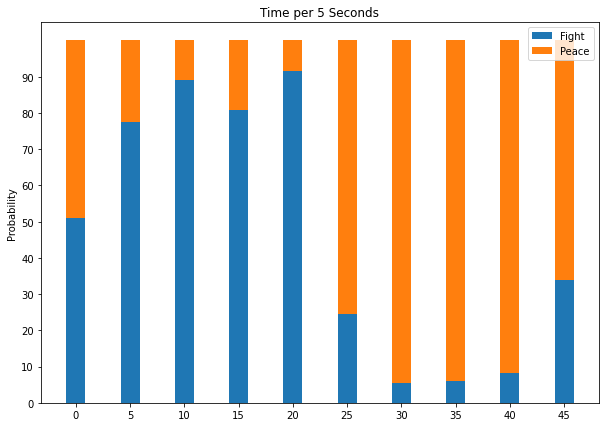

In [27]:
import matplotlib.pyplot as plt
#df = pd.read_csv('E:\\dataset rwf-2000\\RWF2000-Video-Database-for-Violence-Detection-master\\RWF2000-Video-Database-for-Violence-Detection-master\\random testing\\data\\out.csv')
fight = df['Fight_Prob']*100
peace = df['NonFight_Prob']*100

N = len(fight)
width = 0.35 
ind = np.arange(N)
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, fight, width)
p2 = plt.bar(ind, peace, width,
             bottom = fight)

plt.ylabel('Probability')
plt.title('Time per 5 Seconds')
tick = np.arange(0,N*5,5)
np.array(map(str, tick))
plt.xticks(ind, tick)
plt.yticks(np.arange(0, 100, 10))
plt.legend((p1[0], p2[0]), ('Fight', 'Peace'))
 
plt.show()